# QuaSaR: Identifying EEW Rings - Shield Network

[Quake Safe Rings](./1a_stations_faultlnes_plot.ipynb) - in our efforts to understand the station fault topology - we make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) for sharing seismic sensor wave form data. The Obspy librarires support FDSN. The list of resources and services that are used for retrieving station inventory and waveform data.

### Sensor code and type definitions
<a id='sensor_code_desc'></a>

An initiatl step for object 1.A is determining the the types of operational seismic sensors and their locations. GoeNet hosts wave forms for a multitude of [sensor types](https://api.geonet.org.nz/network/sensor/type) (e.g. tidle guages, pressure gauges, seismometers, GNSS antennas, barometers, Microphones, Hydrophones and so on). The focus is on motion sensors of type: _(i) accelerometer, (ii) broadband velocity, (iii) short period velocity, and (iv) GNSS_. 

The sensors location code is unique to each sensor type. Therefore, one may chose to use the location code prefix or sensor type enumerator to select the desired sensors; i.e. seimograph and accelerometer stations. The motion sensors are used in both earthquake and volcanic seismic activity monitoring and early warning.

Channel codes are defined in the GeoNet's [stream naming conventions](https://www.geonet.org.nz/data/supplementary/channels)

| Sensor types that are relevant to earthquake detection | Location codes reserved for the seismic sensors | Channel codes first letter sensor type sampling rate and sensor bandwidth | Channel codes second letter sensor type relevant to seismometers |
|------------------------- |------------------------- |------------------------- |------------------------- |
|1 - Accelerometer |1? - weak motion sensors |U - Ultra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz |H - Weak motion sensor, e.g. measuring velocity |
|3 - Broadband Seismometer |2? - strong motion sensors |V - Very Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz |N - Strong motion sensor, e.g. measuring acceleration |
|4 - GNSS Antenna | |L - Broad band sampled at 1Hz, or SOH sampled at 1Hz |L - Low gain sensor, usually velocity |
|8 - Short Period Borehole Seismometer | |B - Broad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz |M - Mass position, used for monitoring broadband sensors |
|9 - Short Period Seismometer | |S - Short-period sampled at between 10 and 80 Hz, usually 50 Hz | |
|10 - Strong Motion Sensor | |H - High Broad band sampled at or above 80Hz, generally 100 or 200 Hz | |
| | |E - Extremely Short-period sampled at or above 80Hz, generally 100 Hz | |


### DEFINE data services and software modules

We make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) for sharing seismic sensor wave form data. The Obspy librarires support FDSN. The list of resources and services that are used for retrieving station inventory and waveform data. 
1. ObsPy
   1. FSDN as Client data sources; both (i) the FDSN client service and the (ii) FDSN complient GoeNet API webservice
1. FDSN station service
   1. retrieve station metadata information in a FDSN StationXML format or text format for all the channels in CECS station with no time limitations: https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel&format=text


Prepare an array of tuples necessary and sufficient station data:
* _station code_ as a unique identifier
* _coordinates_ longitude & latitude
* _elevation_ in meters above mean sea level

In [38]:
import sys
sys.path.insert(1, '../lib')
import stations

try:
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError
    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} Invalid stations')
    print(f'and {len(invalid_st_list)} VALID active stations.')
    print(f'{invalid_st_list}')
except Exception as err:
    print("Error message:", err)

Retrieving active stations with a 
start-time: 2021-02-11T06:21:00.692525Z 
 & end-time: 2021-02-18T06:21:00.692552Z
FDSN Webservice Client (base url: http://service.geonet.org.nz)
Available Services: 'dataselect' (v1.1), 'event' (v1.1), 'station' (v1.1), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In the inventory of 453 total station
There are 450 Invalid stations
and 3 VALID active stations.
[['CTZ', -43.73549, -176.61719], ['GLKZ', -29.26068, -177.918038], ['RIZ', -29.2449, -177.9289]]


### Plot stations
Color coded plot of stations by type

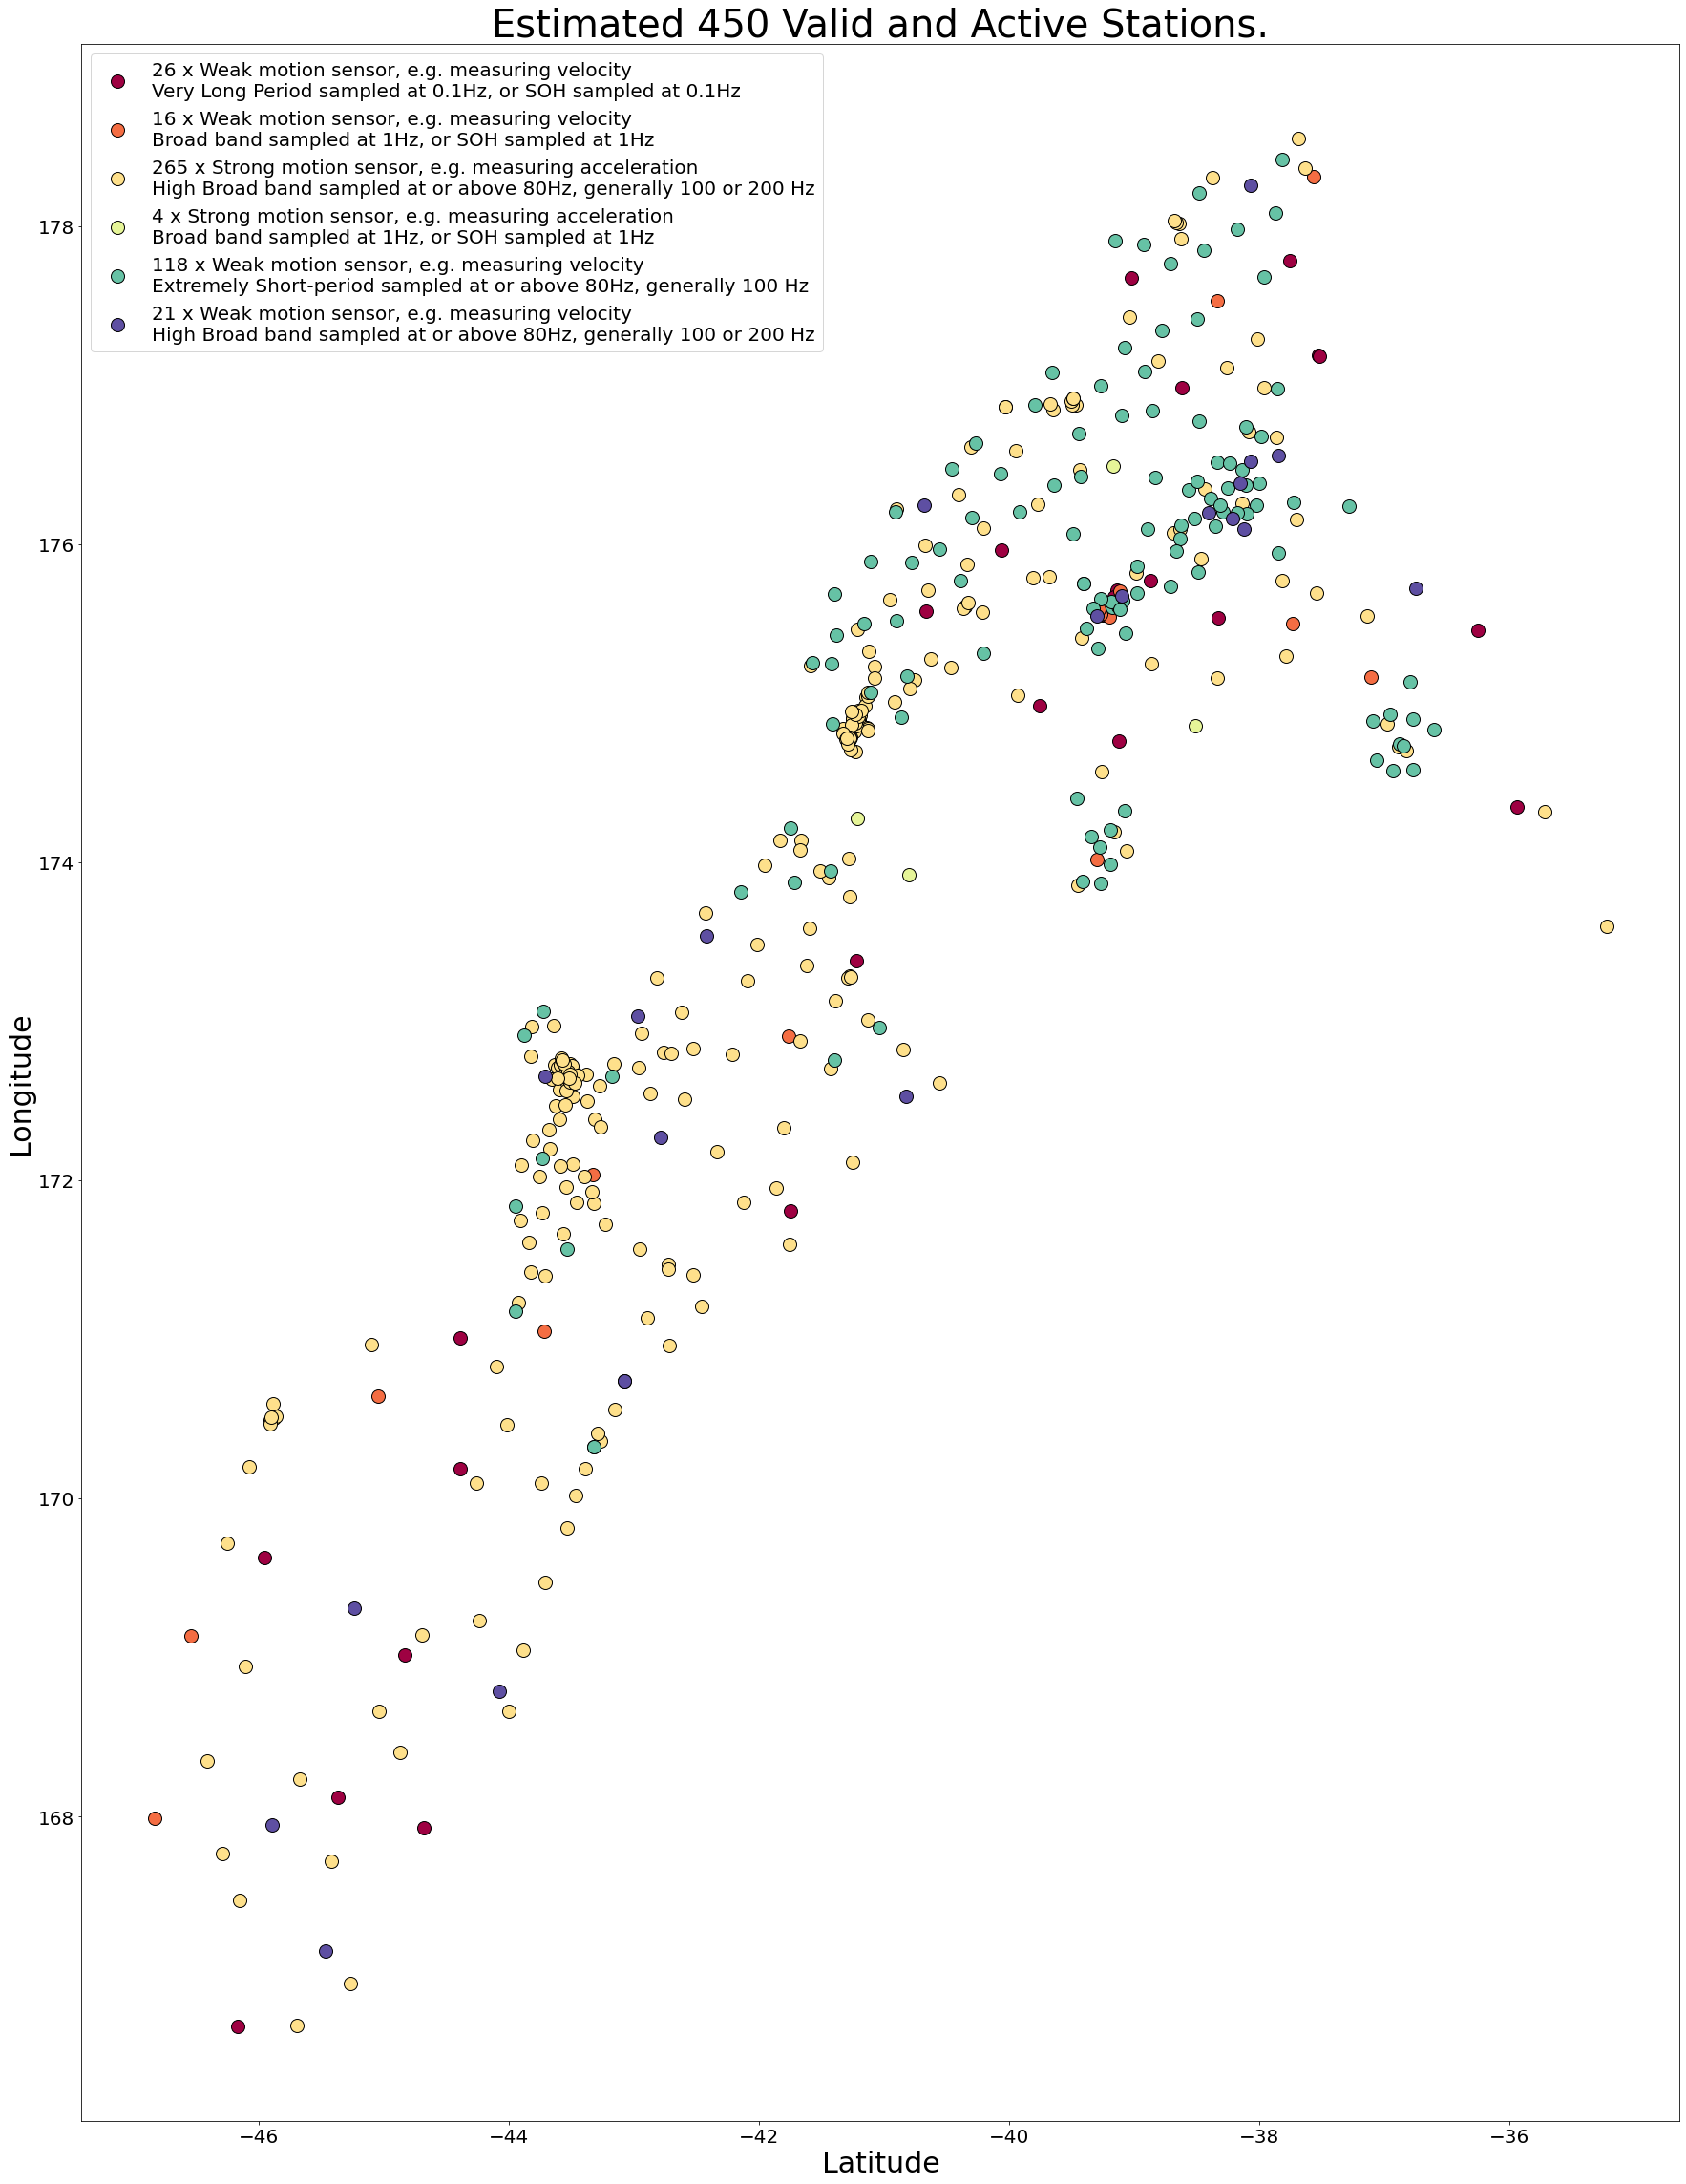

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

lstStationType = []
lstStationLoc = []

''' prepare the list data of station types and coorinate '''
for _,st_type,st_lat,st_lon in st_list:
    lstStationType.append(st_type)
    lstStationLoc.append([st_lat,st_lon])
arrStationLoc = np.array(lstStationLoc)
st_type = cls_st.get_types()

core_samples_mask = np.zeros_like(lstStationType, dtype=bool)
core_samples_mask[0:sum([len(x) for x in lstStationType])] = True

''' assign the color codes to the unique station types '''
unique_st_types = set(lstStationType)
colors = [plt.cm.Spectral(each) 
          for each in np.linspace(0, 1, len(unique_st_types))]

''' Begin plotting the color coded stations '''
plt.figure(figsize=(30, 40))
for k, col in zip(unique_st_types, colors):
    class_member_mask = (np.array(st_type_dict["st_type"]) == k)
    xy = arrStationLoc[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, label=str(len(xy))+' x '+str(st_type[k]))
    
plt.title('Estimated %d Valid and Active Stations.' % len(arrStationLoc), fontsize=40)
plt.xlabel('Latitude', fontsize=30)
plt.ylabel('Longitude', fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()

## OBJECTIVE 1.A - STATION CLUSTERS

### Cluster Stations

Apply DBSCAN to cluster stations with an epsilon < 30Km. DBSCAN is preferred over K-means clustering because K-means clustering considance the variance while DBSCAN considers a distance function. It gives the capacity to build clusters serving the criteria of < 30Km distance between stations.

#### Cluster
1. Apply DBSCAN
   1. Inherent __problem of DBSCAN__ is that it characterises data points to be in the same clusted if pair-wise data points satisfy the epsilon condition. This would not adequately satisfy the required condition that all data points in a a cluster are within the desired epsilon distance.
1. Compute the cluster property measures to estimate the acceptability
1. Dump the output to a file including cluster label, lat/lon, station code, and so on

In [33]:
''' DEPRECATE after converting cell below to call the DBSCAN function in 1c '''

from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

def get_dbscan_labels(st_arr):
    err="0"
    try:
        X, labels_true = make_blobs(n_samples=len(st_arr), centers=st_arr, cluster_std=0.4,random_state=0)
        db = DBSCAN(eps=30.0/6371.0, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
        print('DBSCAN epsilon:',db.eps,'algorithm:', db.algorithm, 'metric: ', db.metric)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
#        print('core samples mask', len(core_samples_mask),core_samples_mask)
        labels = db.labels_
#        print("DBSCAN found %0.3f labels" % labels )
    except Exception as err:
        print("Error message:", err)
        labels = ""
    return labels, labels_true, core_samples_mask

### Parametric analysis of the clusters

A large propotion of the sensors could be clustered to have, at least, 03 senors in a cluster and that they are < 30Km distance from each other; which also is the basis for the ```eps = 30.0/6371.0``` (epsilon convereted to radians using the length of Earth's radius 6371Km). The estimated number of _noise points_ tell us the number of sensors that didn't belong to any cluster. The particular geodedic data cannot be clustered with KD-Trees or any Tree algorithm. However, chosing ```algorithm = "ball_tree"``` is recommended as it is well suited for geospatial data clustering. The ```metric = "haversine"``` is naturally required to calculate the distance between two geographical points. Finally, the ```st_dbscan_arr``` comprising latitude and longitude decimal data is converted to radians to be consistent with using the _haversine_ distance funcation.

In [36]:
# Convert to float to avoid throwing a datatype error in the plot function
station_coordinates = np.array(lstStationLoc).astype(np.float)
# Run dbscan and get the labels
labels, labels_true, core_samples_mask = get_dbscan_labels(station_coordinates)
#print('core samples mask', len(core_samples_mask),core_samples_mask)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Total number of stations: %d' % len(labels))
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print(f"Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(station_coordinates, labels))

DBSCAN epsilon: 0.0047088369172814315 algorithm: ball_tree metric:  haversine
Total number of stations: 450
Estimated number of clusters: 15
Estimated number of noise points: 83
Homogeneity: 0.325
Completeness: 1.000
V-measure: 0.491
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: -0.462


#### Plot results
1. plot clusters with varied colors unique to each cluster
1. plot fault lines to show closes sensor in cluster to the fault line

No handles with labels found to put in legend.


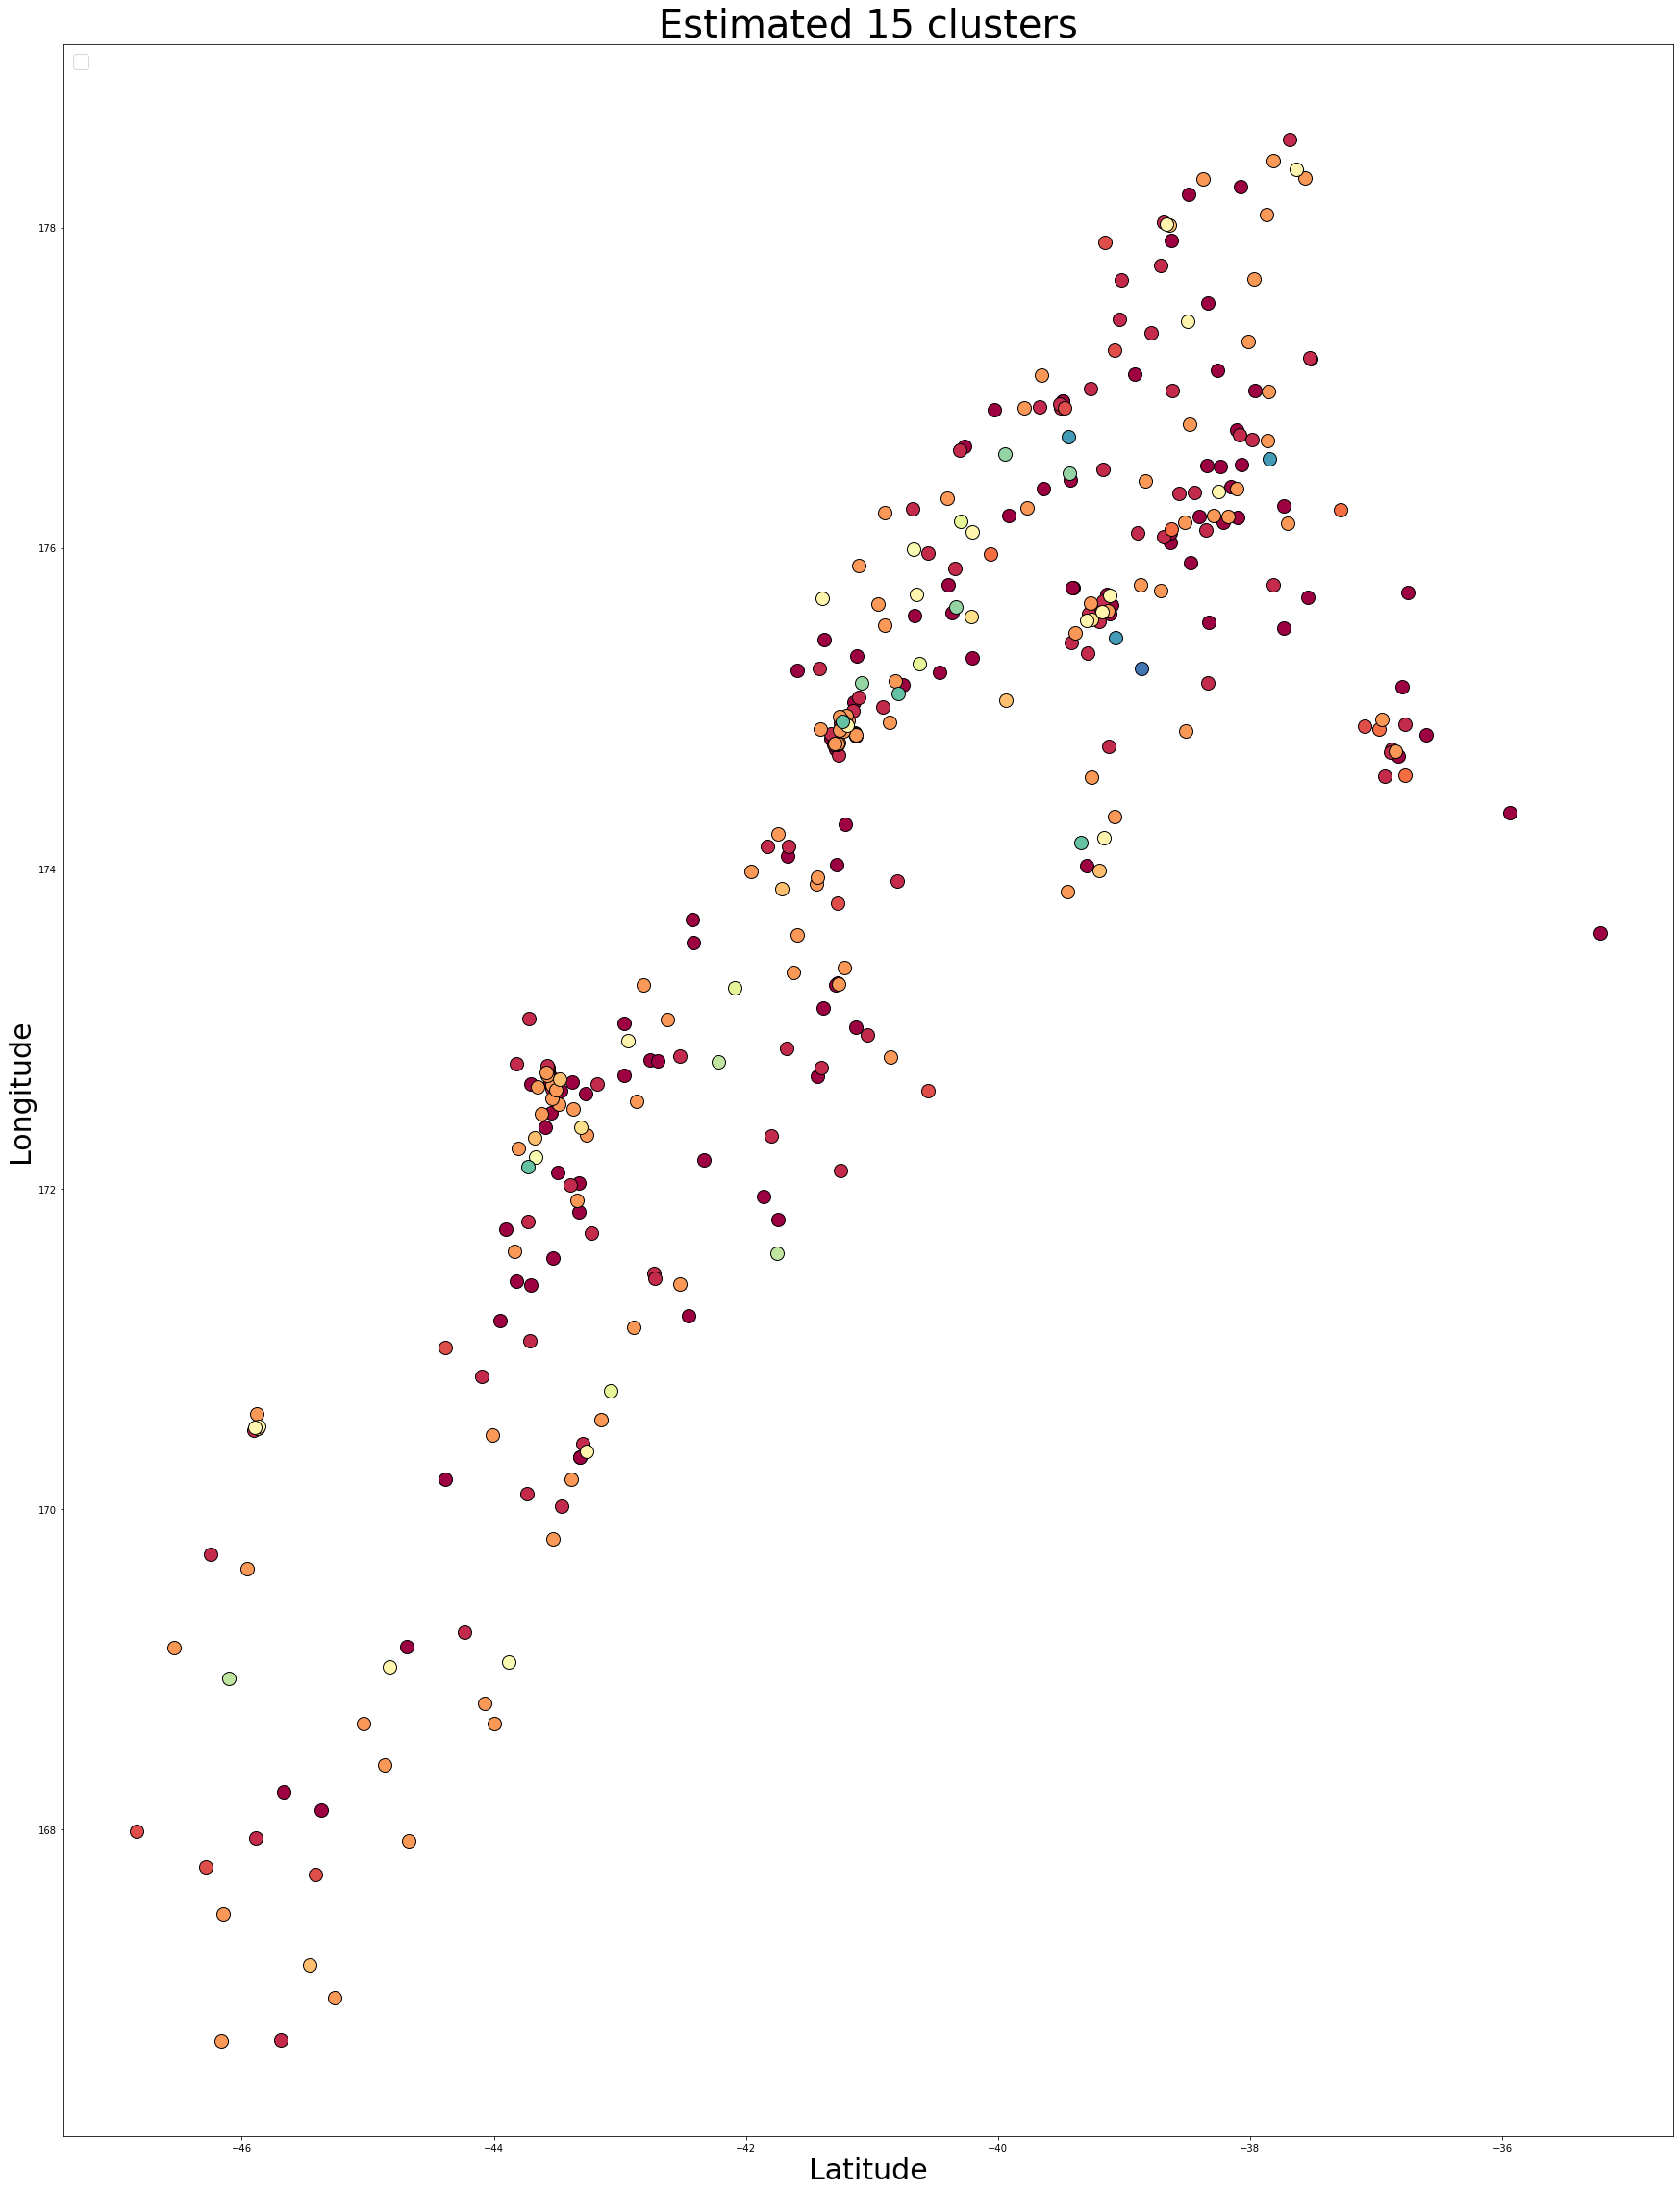

In [39]:
''' PLOT DBSCAN results on a map '''
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(30, 40))
#nz_map = Basemap(width=15000,height=15000,projection='merc',
#            resolution='l',lat_0=-40,lon_0=176.)
#nz_map.drawcoastlines()

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = station_coordinates[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    ''' Uncomment to plot the DBSCAN noise '''
    #xy = station_coordinates[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)

''' TODO add legend '''
plt.title('Estimated %d clusters' % n_clusters_, fontsize=40)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Latitude', fontsize=30)
plt.ylabel('Longitude', fontsize=30)
plt.show()

### Mean Nearest Neighbour Distance Statistics

Compute the mean distance between nearest neigbours of a minimum 3 points
* https://scikit-learn.org/stable/modules/neighbors.html
* https://pysal.org/notebooks/explore/pointpats/distance_statistics.html#Mean-Nearest-Neighbor-Distance-Statistics

In [40]:
''' NOT WORKING maybe redundant '''
from sklearn.neighbors import NearestNeighbors

# Augment station array with cluster number
# Start a new station coorinates and details tuple
st_list = []
i=0
for i in range(len(labels)):
    st_row = [tmp_arr[i,0],labels[i],tmp_arr[i,1],tmp_arr[i,2],tmp_arr[i,3]]
    st_list.append(list(st_row))

clusters = list({item[1] for item in st_list})

for each_cluster in clusters:
    cluster_list = list(st_list[j] for j in range(len(st_list)) if st_list[j][1] == each_cluster)
    cluster_arr = np.delete(cluster_list, [0,1,4],axis=1).astype(np.float)
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute', metric='haversine').fit(cluster_arr)
    distances, indices = nbrs.kneighbors(cluster_arr)
    print(nbrs.kneighbors_graph(cluster_arr).toarray())
    
    each_cluster_clique = client.get_stations(latitude=-42.693,longitude=173.022,maxradius=30.0/6371.0, starttime = "2016-11-13 11:05:00.000",endtime = "2016-11-14 11:00:00.000")
    print(each_cluster_clique)
    _=inventory.plot(projection="local")
    
    break

sorted_rank = sorted(st_list, key=lambda i: (int(i[1])), reverse=True)
#print('Code, Cluster, Latitude, Longitude, Elevation')
#print(sorted_rank)

NameError: name 'tmp_arr' is not defined

### Discussion of DBSCAN results
It is evident from the cluster with large volume of data points are spread across the geography. Therefore, DBSCAN is shown to be innopriate for clustering stations to estimate whether they hold the property of being 30Km within each other.

Next we 

### Fault line coordinates

We have completed objective 1.A. However, we will also include a mapping of the fault lines to give a perception of the station distribution relative to that of the map of fault lines. 

In [32]:
import matplotlib.pyplot as plt 
import json
from dictor import dictor

#plt.figure(figsize=(30, 40))

'''Extract nested values from a JSON tree.'''

try:
    with open('/home/nuwan/workspace/quasar/data/NZAFD/JSON/NZAFD_Oct_2020_WGS84.json') as json_file: 
        data = json.load(json_file)

    for each_feature in range(len(data['features'])):
        points = {"x":[], "y":[]}
        path = dictor(data,'features.{}.geometry.paths.0'.format(each_feature))
        for each_coordinate in range(len(path)):
            points["x"].append(path[each_coordinate][0])
            points["y"].append(path[each_coordinate][1])

except Exception as err:
    print("Error message:", err)